# Q1 - Assignment 9 | ME7223
## Saarthak Marathe - ME17B162

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, solve
from scipy.optimize import minimize
import scipy
import math
import matplotlib.pyplot as plt

In [127]:
def f(x):
    return (x[0]-1)**2+(x[1]-2)**2 - 4

def g1(x):
    return x[0]+2*x[1]-5

def g2(x):
    return 4*x[0]+3*x[1]-10

def g3(x):
    return 6*x[0]+x[1]-7

def diff_f(x):
    df0 = 2*(x[0]-1)
    df1 = 2*(x[1]-2)
    return np.array([df0,df1])

def g_valcheck(x):
    check = [0]*5
    if g1(x) < 0 and g2(x) < 0 and g3(x) < 0 and x[0] > 0 and x[1] > 0:
        return check;
    elif g1(x) == 0:
        check[0] = 1
    elif g2(x) == 0:
        check[1] = 1
    elif g3(x) == 0:
        check[2] = 1
    elif x[0] == 0:
        check[3] = 1
    elif x[1] == 0:
        check[4] = 1
    else:
        return False;
    return check;

def diff_g1(x):
    dg1_x0 = 1
    dg1_x1 = 2
    return np.array([dg1_x0,dg1_x1])

def diff_g2(x):
    dg2_x0 = 4
    dg2_x1= 3
    return np.array([dg2_x0,dg2_x1])

def diff_g3(x):
    dg3_x0 = 6
    dg3_x1=1
    return np.array([dg3_x0,dg3_x1])

def norm(x):
    return math.sqrt(x[0]**2 + x[1]**2)

## Zoutendijk Method

In [128]:
def bestdir_finder(x, cv):
    # this keeps the alpha, s1,s2 as variables until solved
    s = np.array([symbols("s1"), symbols("s2")]) 
    a = symbols("a")
    
    grad_fun = np.dot(s, diff_f(x)) + a
    
    g1_grad, g2_grad, g3_grad = diff_g1(x), diff_g2(x), diff_g3(x)
    x1_grad = np.array([-1, 0])
    x2_grad = np.array([0, -1])
    
    constraint_fun = cv[0]*np.dot(s, g1_grad) + cv[1]*np.dot(s, g2_grad) + cv[2]*np.dot(s, g3_grad) + cv[3]*np.dot(s, x1_grad) + cv[4]*np.dot(s, x2_grad) + a #Calculate s.grad(g_i) for all active constraints
    
    magnitude_fun = np.dot(s.T, s) - 1
    
    s_fun = lambda check: float(-check[2] + max(0, grad_fun.evalf(subs = {s[0]: check[0], s[1]: check[1], a: check[2]}))**2 + max(0, constraint_fun.evalf(subs = {s[0]: check[0], s[1]: check[1], a: check[2]}))**2 + max(0, magnitude_fun.evalf(subs = {s[0]: check[0], s[1]: check[1], a: check[2]})))**2
    
    res = minimize(s_fun, [1, 1, 1])
    best_s = res['x'][:2]
    return (best_s)

def best_step(x, s):
    l = symbols("l")
    x_symb = x + l * s
    f_uni = lambda l: f(x + l * s)
    residual = scipy.optimize.minimize(f_uni, 0)
    opt = residual['x']
    x_new = x + opt * s
    while g_valcheck(x_new) == False:
        opt = opt * 0.8
        x_new = x + opt*s
    return opt

In [129]:
x = np.array([1,1])
coords = [x.tolist()]
x = list(x)
print(0, '- Coordinate:', x, '- Objective Function:', f(x))
i = 0
max_iter = 2
eps = [1e-6]*3
err1, err2 = float('inf'), float('inf')

while err1 > eps[1] and err2 > eps[2] and i<2:
    vec_check = g_valcheck(x)
    if np.sum(vec_check) == 0:
        s = - diff_f(x)
        len_step = best_step(x, s)
        x_new = x + len_step * s
        error2 = abs((f(x) - f(x_new)) / f(x))
        error3 = norm(x - x_new)
        x = x_new
        coords.append(x)

    else:
        s = bestdir_finder(x, vec_check)
        len_step = best_step(x, s)
        x_new = x + len_step * s
        err1 = abs((f(x) - f(x_new)) / f(x))
        err2 = norm(x - x_new)
        x = x_new
        coords.append(x)
    i = i+ 1
    print(i, '- Coordinate:', x, '- Objective Function:', f(x))

0 - Coordinate: [1, 1] - Objective Function: -3
1 - Coordinate: [0.71745035 1.91251145] - Objective Function: -3.9125114471133737
2 - Coordinate: [0.83318267 1.94834676] - Objective Function: -3.969503922544454


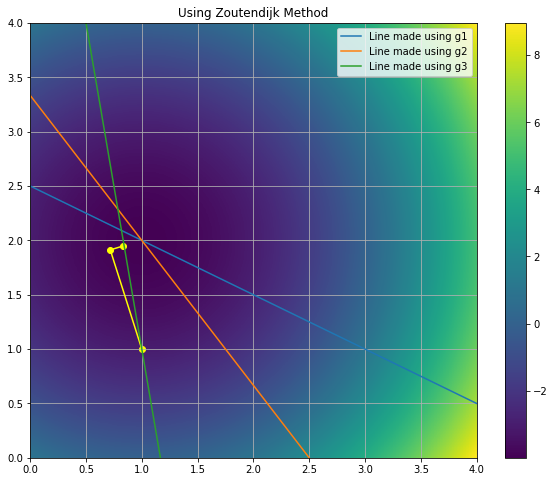

In [130]:
coords = np.array(coords)
xmin = 0
xmax = 4
ymin = 0
ymax = 4
x = np.linspace(xmin,xmax,600)
y = np.linspace(ymin,ymax,600)
xx, yy = np.meshgrid(x, y)
zz = np.array([f(xy) for xy in np.c_[xx.ravel(), yy.ravel()]]).reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.pcolormesh(xx, yy, zz)
plt.colorbar()
plt.plot(coords[:,0], coords[:,1], color = 'yellow')
plt.scatter(coords[:,0], coords[:,1], color = 'yellow')

y1 = (5-x)/2
y2 = (10-4*x)/3
y3 = 7 - 6*x
plt.plot(x,y1, label = 'Line made using g1')
plt.plot(x,y2, label = 'Line made using g2')
plt.plot(x,y3, label = 'Line made using g3')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid()
plt.title('Using Zoutendijk Method')
plt.legend()
plt.show()

## Rosen Gradient Projection Method

In [131]:
def matrix_n(vec):
    #gradients of g1,g2,g3,x0,x1 combined
    diff_mat = np.array([[1,4,6,-1,0],[2,3,1,0,-1]])
    l = np.sum(vec)
    N = np.zeros((2,l))
    j = 0
    for i in range(len(vec)):
        if vec[i] == 1:
            N[:,j] = diff_mat[:,i]
            j += 1
    return N;

def bestdir_finder(x, vec):
    N = matrix_n(vec)
    P = np.eye(2) - np.dot(np.linalg.inv(np.dot(N.T, N)),N.T)
    s = -(np.dot(P.T,diff_f(x)))
    return s

In [132]:
x = np.array([1,1])
coords = [x.tolist()]
x = list(x)
print(0, '- Coordinate:', x, '- Objective Function:', f(x))
i = 0
max_iter = 1
eps = 1e-6
err = norm(diff_f(x))

while err > eps and i<max_iter:
    vec_check = g_valcheck(x)
    if np.sum(vec_check) == 0:
        s = - diff_f(x)
        len_step = best_step(x, s)
        x_new = x + len_step * s
        err = norm(diff_f(x_new))
        x = x_new
        coords.append(x)

    else:
        s = bestdir_finder(x, vec_check)
        step_length = best_step(x, s)
        x_new = x + len_step * s
        error = norm(diff_f(x_new))
        x = x_new
        coords.append(x)

    i += 1
    print(i, '- Coordinate:', x, '- Objective Function:', f(x))

0 - Coordinate: [1, 1] - Objective Function: -3
1 - Coordinate: [0.93357838 1.3985297 ] - Objective Function: -3.633821642119582


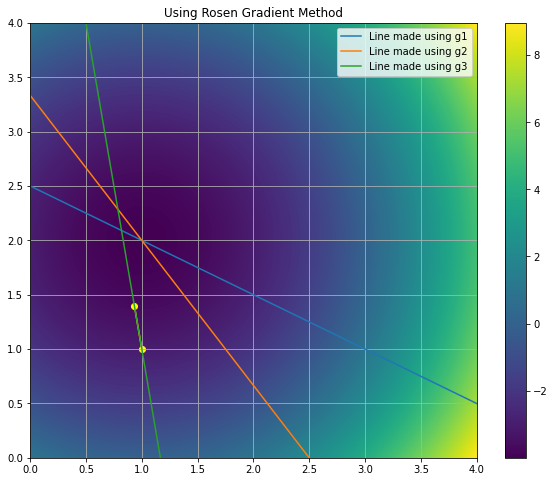

In [133]:
coords = np.array(coords)
xmin = 0
xmax = 4
ymin = 0
ymax = 4
x = np.linspace(xmin,xmax,600)
y = np.linspace(ymin,ymax,600)
xx, yy = np.meshgrid(x, y)
zz = np.array([f(xy) for xy in np.c_[xx.ravel(), yy.ravel()]]).reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.pcolormesh(xx, yy, zz)
plt.colorbar()
plt.plot(coords[:,0], coords[:,1], color = 'yellow')
plt.scatter(coords[:,0], coords[:,1], color = 'yellow')

y1 = (5-x)/2
y2 = (10-4*x)/3
y3 = 7 - 6*x
plt.plot(x,y1, label = 'Line made using g1')
plt.plot(x,y2, label = 'Line made using g2')
plt.plot(x,y3, label = 'Line made using g3')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title('Using Rosen Gradient Method')
plt.grid()
plt.legend()
plt.show()